In [1]:
import cv2
import dlib
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image, ImageOps

import time

In [3]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(6*6*32, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Load pre-trained face detector
model_file = r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Pretrained Detectors\res10_300x300_ssd_iter_140000.caffemodel"
config_file = r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Pretrained Detectors\deploy.prototxt"
face_model = cv2.dnn.readNetFromCaffe(config_file, model_file)

# Load pre-trained landmark predictor
predictor = dlib.shape_predictor(r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Pretrained Detectors\shape_predictor_68_face_landmarks.dat")

# Load CNN eye classifier
eye_model = EyeClassifier()
eye_model.load_state_dict(torch.load(r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\Saved Models\model_DataAug2.pt"))
eye_model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [6]:
# Locates bounding box for a single face
def detect_face(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    face_model.setInput(blob)
    detections = face_model.forward()

    (x1, y1, x2, y2) = 0, 0, 0, 0
    max_confidence = 0

    for i in range(detections.shape[2]):                          
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5 and confidence > max_confidence:      # Only considers predictions with > 0.5 confidence
            (h, w) = img.shape[:2]
            x1 = int(detections[0, 0, i, 3] * w)
            y1 = int(detections[0, 0, i, 4] * h)
            x2 = int(detections[0, 0, i, 5] * w)
            y2 = int(detections[0, 0, i, 6] * h)

            max_confidence = confidence                           # If multiple faces are detected, only return the one with highest confidence

    return dlib.rectangle(x1, y1, x2, y2), max_confidence


# Locates bounding box for a single eye
def detect_eye(img, face):
    landmarks = predictor(img, face)

    if landmarks.num_parts == 0:
        return (0, 0, 0, 0), False
    
    """ Below is some random math I came up with to turn LEFT eye landmarks into a square box, feel free to change"""
    x1 = landmarks.part(17).x                   
    x2 = landmarks.part(21).x
    d = abs(x2-x1)
    k = d * 0.15

    x1 = x1 - int(k/2)
    x2 = x2 + int(k/2)
    y1 = landmarks.part(19).y - int(k/2)
    y2 = y1 + int(d+k)

    return (x1, y1, x2, y2), True

In [8]:
# Prepares an image for CNN eye classifier
def preprocess(img):
    t = transforms.Compose([transforms.Resize([32,32]), 
                            transforms.ToTensor()]) 
                            
    img = Image.fromarray(img).convert("L")
    img = ImageOps.equalize(img)
    img = t(img)

    return img


# Predicts eye state given a single 1x24x24 tensor
def predict_eye_state(img):
    outputs = eye_model(img.unsqueeze(0))
    prob = F.softmax(outputs, dim = 1)
    pred = outputs.argmax(dim = 1).item()

    #print(f"Probabilities: ({prob[0][0]}, {prob[0][1]})")
    #print("Prediction:", pred)

    return pred

In [7]:
# Sample testing code

path = "d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Sample Pictures//open.jpg"
frame = cv2.imread(path)
face, confidence = detect_face(frame)
(x1, y1, x2, y2), eye_found = detect_eye(frame, face)
if eye_found:
    # Eye state classification
    eye = frame[y1:y2, x1:x2]
    eye = preprocess(eye)
    pred = predict_eye_state(eye)
    # perclos_list.append(pred)
    print(pred)
    

1


In [9]:
# Read the KSS file (DROZY Dataset for testing)

f = open(r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\DROZY\DROZY\KSS.txt", "r")
list1 = []
string = f.read()
string_mod = string.replace("\n", ",")
list1 = string_mod.split(",")
for i in range(len(list1)):
    list1[i] = list1[i].split(" ")

print(list1)

def get_kss_drozy(filename, array):
    # Assuming the filename -> "1-2.mp4" or "11-2.mp4"
    if len(filename) == 7:
        index1 = int(filename[0])-1
        index2 = int(filename[2])-1
    else:
        index1 = int(filename[1])+9
        index2 = int(filename[3])-1
    return array[index1][index2]

get_kss_drozy("11-1.mp4", list1)

[['3', '6', '7'], ['3', '7', '6'], ['2', '3', '4'], ['4', '8', '9'], ['3', '7', '8'], ['2', '3', '7'], ['0', '4', '9'], ['2', '6', '8'], ['2', '6', '8'], ['3', '6', '7'], ['4', '7', '7'], ['2', '5', '6'], ['6', '3', '7'], ['5', '7', '8']]


'4'

In [14]:
cap = cv2.VideoCapture(r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\DROZY\DROZY\videos_i8\1-1.mp4")    
#cap = cv2.VideoCapture("./Datasets/X/04/5.mp4")   
#cap = cv2.VideoCapture(0)

perclos_list = []
closed_list = []

counter = 0
while cap.isOpened():
    if counter > 999:
        break
    ret, frame = cap.read()     # return status and image
    if not ret:
        print("Can't retreive frame")
        break
    # print(ret)
    # break

    time.sleep(0.05)             # too see blinks clearly

    # Face detection
    face, confidence = detect_face(frame)
    # print(confidence)
    # break

    if confidence > 0:

        # Eye detection
        (x1, y1, x2, y2), eye_found = detect_eye(frame, face)

        if eye_found:
            # Eye state classification
            eye = frame[y1:y2, x1:x2]
            eye = preprocess(eye)
            pred = predict_eye_state(eye)
            perclos_list.append(pred)

            """ADD KSS IF AND ELSE STATEMENTS"""

            if(pred == 0):
                cv2.putText(frame, "Closed", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                closed_list.append(pred)

        # Rectangle visuals
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
        confidence_txt = "{:.2f}%".format(confidence * 100)
        cv2.putText(frame, confidence_txt, (face.left(), face.top()), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)


    # Display frame
    # cv2.imshow("img", frame)

    # Exit window using "q" key
    if cv2.waitKey(1) == ord("q"):
        break
    counter+=1


cap.release()
cv2.destroyAllWindows()

print("perclos_list: ", len(perclos_list))
print("closed list: ", len(closed_list))

KeyboardInterrupt: 

In [10]:
# path = "d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Datasets//DROZY/videos_i8//1-2.mp4"
# kss_path = "d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Datasets//DROZY//KSS.txt"

In [15]:
def kss(x):
    '''
    if and else statements of KSS
    '''
    if x == 1:
        return "Extremely Alert"
    elif x == 2:
        return "Very Alert"
    elif x == 3:
        return "Alert"
    elif x == 4:
        return "Rather Alert"
    elif x == 5:
        return "Neither alert nor sleepy"
    elif x == 6:
        return "Some signs of sleepiness"
    elif x == 7:
        return "Sleepy, but no effort to keep awake"
    elif x == 8:
        return "Sleepy, but some effort to keep awake"
    elif x == 9:
        return "Very sleepy. great effort to keep awake, fighting sleep"
    elif x == 10:
        return "Extremely sleepy, can't keep awake"

In [16]:
def _map(x, in_min, in_max, out_min, out_max):
    return float((x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min)

_map(4, 1, 9, 0, 0.15)

0.056249999999999994

In [18]:
# Testing Code

vid_peth = r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\DROZY\DROZY\videos_i8\11-1.mp4"


if vid_peth[-8] == "/":
        per_inde = int(vid_peth[-7])-1
        vid_inde = int(vid_peth[-5])-1
else:
    per_inde = 9+int(vid_peth[-7])
    vid_inde = int(vid_peth[-5])-1
print("person: ", per_inde)
print("vid: ", vid_inde)


person:  10
vid:  0


In [19]:
def detection_kss(vid_path, kss_path):
    '''
    Takes in the path of the video, path of the kss file. 
    '''
    cap = cv2.VideoCapture(vid_path)    
    #cap = cv2.VideoCapture("./Datasets/X/04/5.mp4")   
    #cap = cv2.VideoCapture(0)

    perclos_list = []
    closed_list = []

    # video_number = vid_path[]

    if vid_path[-8] == "/":
        per_index = int(vid_path[-7])-1
        vid_index = int(vid_path[-5])-1
    else:
        per_index = 9+int(vid_path[-7])
        vid_index = int(vid_path[-5])-1

    counter = 0
    while cap.isOpened():
        if counter > 999:
            break
        ret, frame = cap.read()     # return status and image
        if not ret:
            print("Can't retreive frame")
            break
        time.sleep(0.05)             # too see blinks clearly
        # Face detection
        face, confidence = detect_face(frame)
        if confidence > 0:
            # Eye detection
            (x1, y1, x2, y2), eye_found = detect_eye(frame, face)
            if eye_found:
                # Eye state classification
                eye = frame[y1:y2, x1:x2]
                eye = preprocess(eye)
                pred = predict_eye_state(eye)
                perclos_list.append(pred)
                if(pred == 0):
                    cv2.putText(frame, "Closed", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                    closed_list.append(pred)
            # Rectangle visuals
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
            cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
            confidence_txt = "{:.2f}%".format(confidence * 100)
            cv2.putText(frame, confidence_txt, (face.left(), face.top()), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)
        # Display frame
        # cv2.imshow("img", frame)

        # Exit window using "q" key
        if cv2.waitKey(1) == ord("q"):
            break
        counter+=1
    cap.release()
    cv2.destroyAllWindows()

    # add kss if and else and attach the kss function
    print("Total number of frames: ", len(perclos_list))
    print("Closed eyes in the list: ", len(closed_list))
    perclos_deno = len(perclos_list)
    perclos_nume = len(closed_list)
    perclos_value = (perclos_nume / perclos_deno)

    # print(perclos_value)

    f = open(kss_path, "r")
    list1 = []
    string = f.read()
    string_mod = string.replace("\n", ",")
    list1 = string_mod.split(",")
    for i in range(len(list1)):
        list1[i] = list1[i].split(" ")

    kss_val = int(list1[per_index][vid_index])

    # print(kss_val)
    # mapping the KSS value to the % values of PERCLOS to calculate the error
    mapped_kss_val = _map(kss_val, 1, 9, 0, 0.15)

    print("The mapped value of KSS is: ", mapped_kss_val)

    # add if and else for drowsineess
    if perclos_value <= 0.0375:
        print("Model predicts: Low drowsiness")
    elif 0.0375 < perclos_value <= 0.075:
        print("Model predicts: Low drowsiness")
    elif 0.075 < perclos_value <= 0.1125:
         print("Model predicts: Moderate Drowsiness")
    elif 0.1125 < perclos_value <= 0.15:
        print("Model predicts: Moderate Drowsiness")
    else:
        print("Severe Drowsiness")

    kss_return_statement = kss(kss_val)

    print("The KSS rating is: ", kss_val)
    print("The KSS value is: ", kss_return_statement)

    return mapped_kss_val, perclos_value



In [20]:
video_69 = r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\DROZY\DROZY\videos_i8\11-1.mp4"
kss_69 = r"C:\Users\alast\OneDrive\Desktop\driver_drowsiness\driver-drowsiness-detection-main\DROZY\DROZY\KSS.txt"

detection_kss(video_69, kss_69)

# loop thru all the videos in drozy and output the perclos values in a list. Compare error with corresponding KSS values and plot

Total number of frames:  1000
Closed eyes in the list:  90
The mapped value of KSS is:  0.056249999999999994
Model predicts: Moderate Drowsiness
The KSS rating is:  4
The KSS value is:  Rather Alert


(0.056249999999999994, 0.09)

In [22]:
video_dir = "C://Users//alast//OneDrive//Desktop//driver_drowsiness//driver-drowsiness-detection-main//DROZY//DROZY//videos_i8//"
kss_path = "C://Users//alast//OneDrive//Desktop//driver_drowsiness//driver-drowsiness-detection-main//DROZY//DROZY//KSS.txt"


os.chdir("C://Users//alast//OneDrive//Desktop//driver_drowsiness//driver-drowsiness-detection-main//DROZY//DROZY//videos_i8")
videos_1 = os.listdir()

error_list = []

for video in videos_1:
    video_path = video_dir + video
    kss_fvalue, percos_fvalue = detection_kss(video_path, kss_path)
    #add error function to the code
    if percos_fvalue == kss_fvalue:
        error_list.append(100.0)
    else:
        error_list.append((abs(percos_fvalue - kss_fvalue) / kss_fvalue) * 100.0)
error_list

Total number of frames:  1000
Closed eyes in the list:  69
The mapped value of KSS is:  0.0375
Model predicts: Low drowsiness
The KSS rating is:  3
The KSS value is:  Alert
Total number of frames:  1000
Closed eyes in the list:  53
The mapped value of KSS is:  0.09375
Model predicts: Low drowsiness
The KSS rating is:  6
The KSS value is:  Some signs of sleepiness
Total number of frames:  1000
Closed eyes in the list:  100
The mapped value of KSS is:  0.11249999999999999
Model predicts: Moderate Drowsiness
The KSS rating is:  7
The KSS value is:  Sleepy, but no effort to keep awake
Total number of frames:  1000
Closed eyes in the list:  68
The mapped value of KSS is:  0.0375
Model predicts: Low drowsiness
The KSS rating is:  3
The KSS value is:  Alert
Total number of frames:  1000
Closed eyes in the list:  83
The mapped value of KSS is:  0.11249999999999999
Model predicts: Moderate Drowsiness
The KSS rating is:  7
The KSS value is:  Sleepy, but no effort to keep awake
Total number of fr

[84.00000000000001,
 43.46666666666667,
 11.111111111111098,
 81.33333333333336,
 26.222222222222214,
 60.00000000000001,
 79.55555555555556,
 81.33333333333333,
 236.0,
 63.733333333333334,
 174.66666666666669,
 97.33333333333333,
 64.44444444444444,
 96.19047619047618,
 17.333333333333332,
 75.11111111111114,
 4.533333333333337,
 14.66666666666666,
 81.33333333333333,
 18.222222222222214,
 39.55555555555554,
 8.32490731378497,
 69.33333333333334,
 100.0,
 98.22222222222223,
 100.0,
 134.66666666666666,
 52.000000000000014,
 29.77777777777777,
 1071.5555555555557,
 76.00000000000001,
 316.0,
 6.666666666666672,
 1.615901615901617,
 31.73333333333333,
 54.28571428571429]

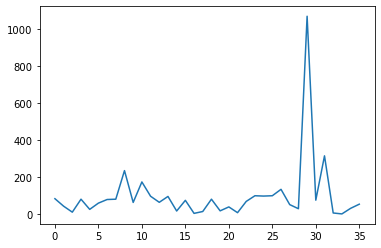

In [23]:
# Plot the error

from matplotlib import pyplot as plt

plt.plot(error_list)
plt.show()